# **TFPM: Evaluating a Defender's Tackling Ability**
By Ryan Hermes

# Introduction

Assessing a team's defensive performance in football comes down to a crucial aspect: stopping the offense from gaining yards. At the core of this lies the fundamental skill of tackling - an essential task that determines a defender's effectiveness.

Traditional metrics used to assess defensive players often fall short in fairly evaluating a player’s contribution. Metrics like Tackles or Sacks, while informative, provide an incomplete picture of a player's overall defensive impact. This limited perspective overlooks the different duties of the various defensive positions. For instance, positions like Inside Linebackers frequently engage in more tackling opportunities due to their primary responsibility in stopping run plays. Conversely, positions such as safeties might have fewer tackling chances in comparison to linemen since they aren’t actively on the line of scrimmage. Nevertheless, their importance to the team is undoubtedly significant.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv('/kaggle/input/tfpm-data/TFPM_data.csv')

# Tackle Factor (TF)

In 1977, Bill James, a pioneer in baseball statistics, introduced [Range Factor (RF)](https://www.mlb.com/glossary/advanced-stats/range-factor), a groundbreaking metric designed to fairly evaluate the defensive abilities of baseball fielders. RF revolutionized player assessment by quantifying a player's defensive dominance within their  position, rather than comparing them to other players on the field. James's concept of position specific metrics kickstarted a revolution in sports analytics, and suggested applicability in other sports. 

In football, [Brian Burke](https://www.advancedfootballanalytics.com/2010/03/tackle-factor.html) proposed a similar approach with a new metric known as Tackle Factor (TF). TF serves to evaluate a player’s abilities relative to their expected performance within their defensive position on the field. TF is calculated as:

$Tackle\ Factor\ (TFi)=\frac{T\ +\ 0.5A}{ASTp}$

Where T = tackles, A = assists and AST represents the average successful tackles for position p, adjusted for games played.

For instance, a player with a TF of 1.23 demonstrates an ability to make 23% more tackles than the anticipated average for their position, signifying their value as a defender. Conversely, a TF below 1 suggests a player might be underperforming compared to their positional expectations.

Additionally, TF lacks comparative value when assessing players across different defensive positions, due to the divergent expectations inherent to each role. For example, TF would be an unfair metric to compare a NT to an OLB, since their positions have very different responsibilities. A Nose Tackler’s focus usually revolves around disrupting offense, and while they do execute tackles, their primary role involves creating pressure unlike Outside Linebackers who aim to tackle the ball carrier. To illustrate this, here is the distribution of TF’s across various defensive positions:

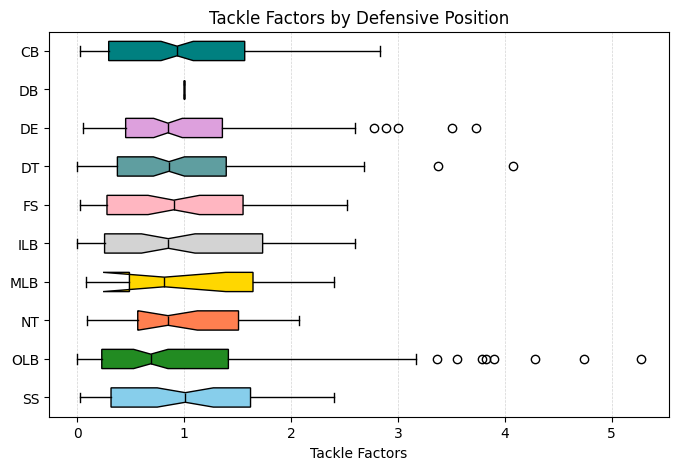

# Positional Performance Factors

As mentioned earlier, various defensive positions demand unique skill sets and attributes. These specific requisites define the effectiveness of players within their roles. Let's delve into the specifics, starting with Outside Linebackers (OLBs). The following figure illustrates the distribution of Tackle Factor scores among active NFL OLBs:

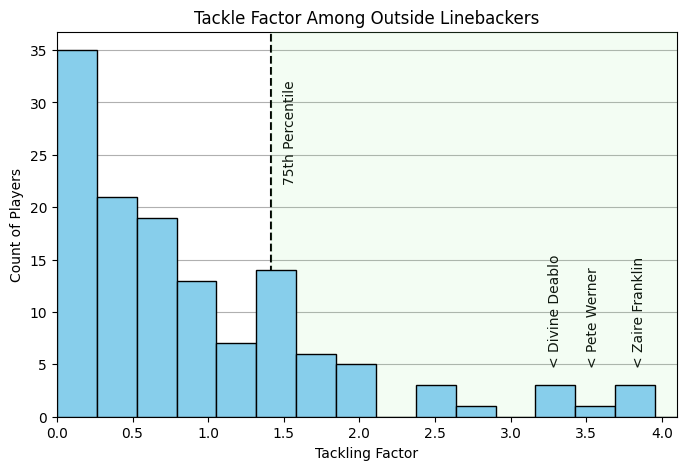

In examining the distribution of Tackle Factor scores among active OLBs, distinctive outliers emerge, showcasing exceptional tackling performance within this role. What distinguishes these players from the rest? [As suggested by Michael Nania,](https://jetsxfactor.com/2020/05/26/the-five-key-traits-that-make-up-a-strong-tackler-on-defense/) the two most important traits of a strong OLB are **explosiveness and speed**.

**Explosive Acceleration:** Swift acceleration helps defenders react swiftly to changes in play, close down opponents, and cover spaces effectively. Acceleration is crucial for intercepting passes, recovering from positional errors, or chasing down attackers. Nania emphasizes: “How quickly can the player diagnose the play and identify where the ball is going? From there, how quickly can he plant his feet, break, and hit top speed?”

**Top Speed:** High top speed is beneficial for defenders when facing rapid attackers or when caught out of position. It helps in recovery runs to track back and prevent opponents from breaking through the defensive line.

Let’s take note of the three OLB’s with the highest TF (Zaire Franklin, Pete Werner, and Divine Deablo), and see where they compare against other OLB’s in both speed and acceleration.

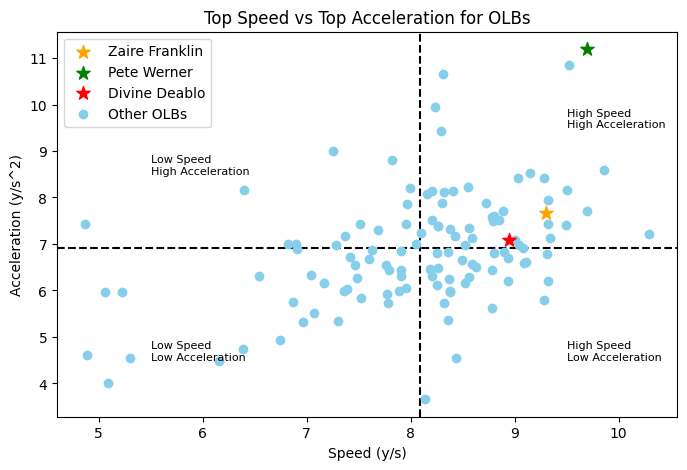

It’s no surprise that the best performing OLB’s (as measured by their Tackle Factor) also dominate in speed and acceleration. However, this data only shows the results of outside linebackers. In positions such as Defensive Tackle, speed or acceleration are undoubtedly important, but not as critical as other prerequisites. According to Coach Martin (Football Advantage), the most important characteristic of a Defensive Tackle **[is size](https://footballadvantage.com/defensive-tackle/)**. Additionally, reliability (as measured by Tackle Efficiency) is also an important skill for a DT to have.

**BMI (Body Mass Index):** A defender's BMI serves as an indicator of a player's build and strength. A higher BMI often suggests a greater physical presence, which can prove advantageaous in winning physical battles, holding field position, and fending off opponents. As articulated by Martin: “A defensive tackle needs to make it difficult for offensive linemen to move him where they want to. One easy way to do that is to simply be big”.

**Tackle Efficiency:** Tackle Efficiency is a pivotal metric reflecting a defender's success in tackling. A high tackle efficiency signifies good decision-making, timing, technique, and the ability to dispossess opponents reliably without committing penalties.

In the figure below, we see that Grover Steward, Christian Wilkins, and A’Shawn Robinson have the highest TF out of all Defensive Tackles on the histogram. On the right, we see how they rank in BMI and Tackle Efficiency compared to other DT's on the scatterplot.

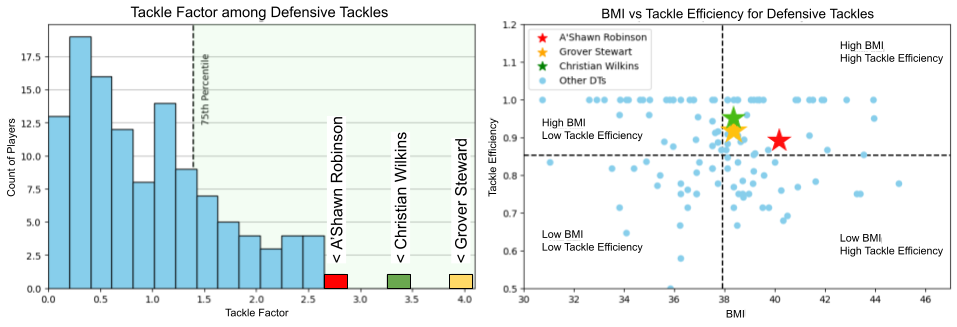

Unsuprisingly, the top performing DT’s (as measured by their TF) demonstrate above average size and efficiency. BMI and Tackle Efficiency do a pretty good job predicting a DT’s TF on their own. However, it's important to acknowledge that speed and acceleration are still important for all positions. In fact, incorporating speed and acceleration on top of BMI and Tackle Efficiency in the evaluation process will provide an even more accurate assessment of defensive players.

The figure below illustrates how various defensive positions demand distinct skill sets. Each axis represents one of the crucial attributes we've looked at so far—speed, acceleration, BMI, and tackle efficiency—showcasing their varying importance across four different defensive responsibilities.

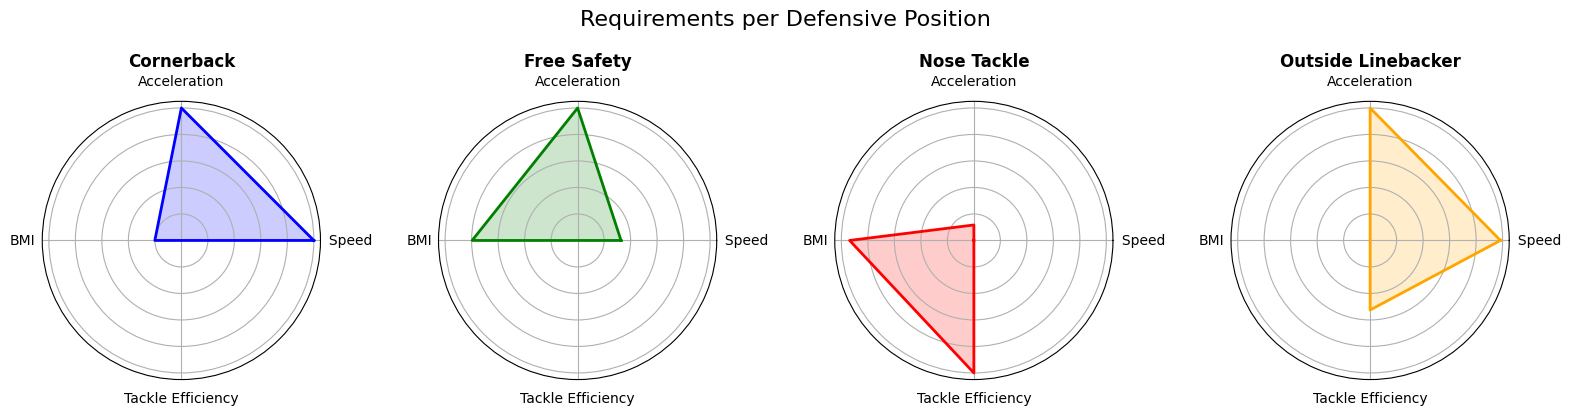

Having highlighted the relevance of speed, acceleration, efficiency, and BMI in top-tier defensive players, our focus now shifts to building a comprehensive evaluation framework that incorporates all four factors. The Tackle Factor Predictive Model (TFPM) incorporates these key attributes—tailoring its assessments based on the different positions.

# TFPM: Tackle Factor Predictive Model

While TF was a robust estimator of how valuable a player was, it a has a few caveats that need to be addressed. 

**1. It factors in the performance of team members.** Inherently, TF aims to predict a player’s abilities. However, leakage can occur due to the situations a player experiences created by a their teammates. For instance, a standout Safety in a comparatively weaker defense may accumulate a higher proportion of the team's tackles, potentially inflating their TF. Recognizing this, we must be careful not to overemphasize a player's contribution when, in reality, other safeties from different teams might perform equally well if placed in similar situations.

**2. It requires data.** TF relies on existing data, posing a limitation when evaluating new players with minimal on-field experience. This can make it difficult to calculate a player's Tackle Factor if they have limited data.

This is where TFPM (Tackle Factor Predictive Model) gains its relevance. TFPM can compensate for both a lack of data, and smooth out discrepancies across same-position defenders on different teams. Instead, of evaluating a player soley by their TF, TFPM estimates a player's value based on the important characteristics they possess. Additionally, TFPM adapts to each unique defensive position, considering speed, acceleration, BMI, and efficiency. This holistic approach provides a complete and well-rounded view of a player’s performance.

#### Data Preparation
In order to prepare the data needed to build TFPM, we must:
1. Concatenate the tracking data, and identify the top acceleration & speed of each player.
2. Trim the play data to only include plays where any tackle attempts were present.
3. Implement feature engineering to calculate each player's BMI, Tackle Efficiency, and Tackle Factor.

Given the time-consuming nature of this process, the details & code are excluded from this notebook. However, for those interested, the code responsible for transforming the original NFL NextGen Data into the TFPM dataset can be found [here, on my GitHub](https://github.com/rryanhermes/Tackle-Factor-Predictive-Model).

Below is a sample from the finalized TFPM dataset.

In [2]:
styled_data = df.iloc[:, :-2].head().style
styled_data

,nflId,position,displayName,a,s,tackle_efficiency,bmi,tackle_factor
0,54948,NT,Marquan McCall,4.800000,5.660000,1.000000,47.366578,0.565854
1,43694,NT,Michael Pierce,5.570000,6.510000,1.000000,46.107253,0.565854
2,48198,NT,Bryan Mone,5.800000,6.620000,0.866667,45.741867,1.226016
3,41336,DT,Justin Ellis,4.390000,7.150000,0.777778,44.932432,0.750554
4,44957,DT,Grover Stewart,5.500000,7.520000,0.926829,38.338816,4.074435


#### Building the TFPM Model
Since TF isn't an exact science, predicting a player's tackling proficiency through regression might not yield accurate results. Instead, we opt to divide all defenders into two groups based on their performance, segmented by the 75th percentile of TF scores. The 75th percentile performance benchmark was chosen because it clearly represents above-average performance and balances the representation of the majority [while managing outliers](https://support.speedcurve.com/docs/average-median-percentiles). The goal is to construct a binomial classification model, determining whether a defender falls above or below the 75th percentile of performance in their position, using the four observed variables (Acceleration Speed, Top Speed, BMI, and Tackle Efficiency). To achieve this, we use [XGBoost](https://xgboost.readthedocs.io/en/stable/), a popular machine learning library known for its speed and accuracy.

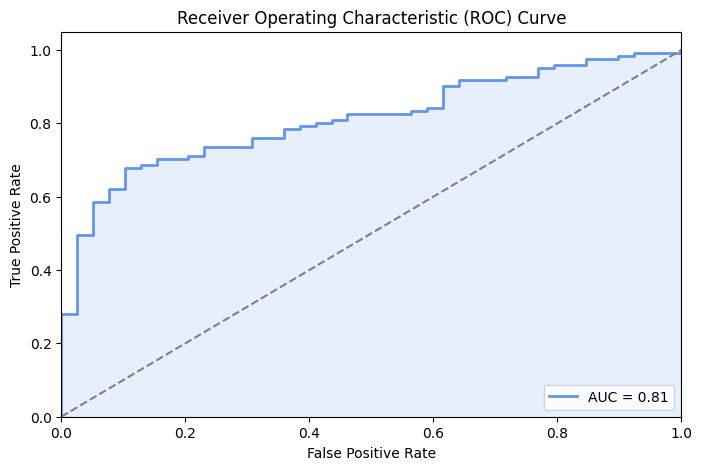

In [3]:
# Define target variable and feature columns
target_variable = '75th_percentile_category'
feature_columns = ['bmi', 'tackle_efficiency', 'a', 's']
y, x = df[target_variable], df[feature_columns]

# Encode variables
x = pd.get_dummies(x)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=1)

# Initialize XGBoost
model = xgb.XGBClassifier(random_state=1, n_jobs=-1)

# Perform a Grid Search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
param_grid = {'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7]}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Calculate accuracy
best_model = grid_search.best_estimator_
predictions = best_model.predict(x_test)
accuracy = accuracy_score(y_test, predictions)

# Compute the ROC curve & score
y_probabilities = best_model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='cornflowerblue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.fill_between(fpr, tpr, color='cornflowerblue', alpha=0.15)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.show()

In the figure above, we assess the TFPM Model’s performance using a Receiver Operating Characteristic curve (ROC). This curve measures the model's ability to distinguish whether a player falls above or below the 75th percentile in tackling performance. The Area Under the Curve (AUC) quantifies the model’s effectiveness in identifying good tacklers. An AUC of 0.81 implies that our model has a strong ability to discriminate between our two groups. With .75 as our performance benchmark and True Positive Range (TPR) and False Positive Range (FPR) representing the model's accuracy, AUC is calculated by the formula:

$\text{AUC} = \int_0^1 \text{TPR}(.75) \,d(\text{FPR}(.75))$

Additionally, the decision to include GridSearchCV for hyperparameter optimization and cross-validation for improving the model's integrity notably contributed to TFPM's robustness. GridSearchCV fine-tuned the model parameters, optimizing its predictive capacity and improved upon our statistical assumptions programmatically. Simultaneously, cross-validation ensured the model's reliability by assessing its performance across multiple chunks of data, which helps to alleviate overfitting. Together, these methodologies enhanced TFPM's accuracy and useability in evaluating defensive players' tackling abilities.

Importantly, all four factors—Tackle Efficiency, Speed, Acceleration, and BMI—have demonstrated their significance in player evaluation. This significance is calculated by determining the gain per feature divided by the total gain, representing the respective contribution of each feature to the model's accuracy. Among these, Tackle Efficiency and Speed emerge as the most crucial features, each accounting for 28% of the model's success, followed by Acceleration and BMI, both contributing 22%.

# How is this useful to the NFL?

TFPM emerges as a valuable tool for both individual teams and the league as a whole. In practical terms, the TFPM model assesses a player based on key metrics- position, speed, acceleration, BMI, and efficiency- to determine whether the player will help the team lock down the opponent's offense. If an NFL team lacks defensive talent, they can utilize the Tackle Factor Predictive Model to scout players who may turn things around through tackling.

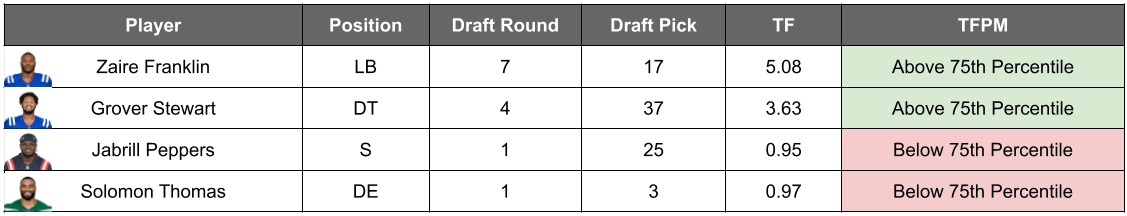

Another benefit of TFPM is it's ability to discover potential star players who might be overlooked. **For example, two of the players that the Tackle Factor Predictive Model discovered (Zaire Franklin and Grover Steward) weren't ranked high in their drafts, but proved their outstanding tackling & defensive abilities on the field.** Steward was a part of the fourth round in 2017, and Franklin was in round seven of 2018. Regardless of their draft standings, they both were drafted by the Indianapolis Colts and have been a crucial part of the Colts' improvement in defense over the past few years. While Peppers and Thomas are good players overall, they were high priority draft picks that were expensive due to their expected performance.

# Appendix

For a thorough walkthrough on how the data was gathered in preparation for the Tackle Factor Prediction Model, visit [my GitHub repo](https://github.com/rryanhermes/Tackle-Factor-Predictive-Model).

Email: rryanhermes@gmail.com

LinkedIn: https://www.linkedin.com/in/ryanhermes/

Citations:
* James, Bill. “Range Factor.” Wikipedia, Wikimedia Foundation, 14 June 2023, en.wikipedia.org/wiki/Range_factor. 
* Burke, Brian. “Tackle Factor.” Advanced Football Analytics (Formerly Advanced NFL Stats), 2010, advancedfootballanalytics.com/2010/03/tackle-factor.html. 
* Nania, Michael. “Ny Jets Film Breakdown - Key Skills behind Making a Bone-Shattering Tackle.” Factor, 26 May 2020, jetsxfactor.com/2020/05/26/the-five-key-traits-that-make-up-a-strong-tackler-on-defense/. 
* Martin, Coach. “What Is a Defensive Tackle in Football? (DT Position Guide).” Football Advantage, 30 May 2023, footballadvantage.com/defensive-tackle/.
* “Averages, Medians & Percentiles.” SpeedCurve, support.speedcurve.com/docs/average-median-percentiles. Accessed 7 Jan. 2024. 